# Hopf Specific Visualization

In [1]:
import os
os.chdir("../")

In [2]:
import glob
import gzip
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from modelproblem import ModelProblem
from petab.visualize import plot_problem
from weighted_quantile import weighted_quantile
from result_classes import Result,MethodResults

In [3]:
prob_name = "Hopf"
methods = ["ptmcmc", "smc", "pmc"]

mod_prob = ModelProblem(prob_name)
mod_prob.initialize()
colors = sns.color_palette("tab10", n_colors=len(methods))

grouped_results = [MethodResults(x) for x in methods]

for method, group_obj in zip(methods, grouped_results):
	result_dir = f"results/{prob_name}/{method}/"
	fnames = glob.glob(result_dir + "*.pkl")
	for fname in fnames:
		with gzip.open(fname, "rb") as f:
			results = pickle.load(f)
		result_obj = Result(results)
		group_obj.add_result(result_obj)			

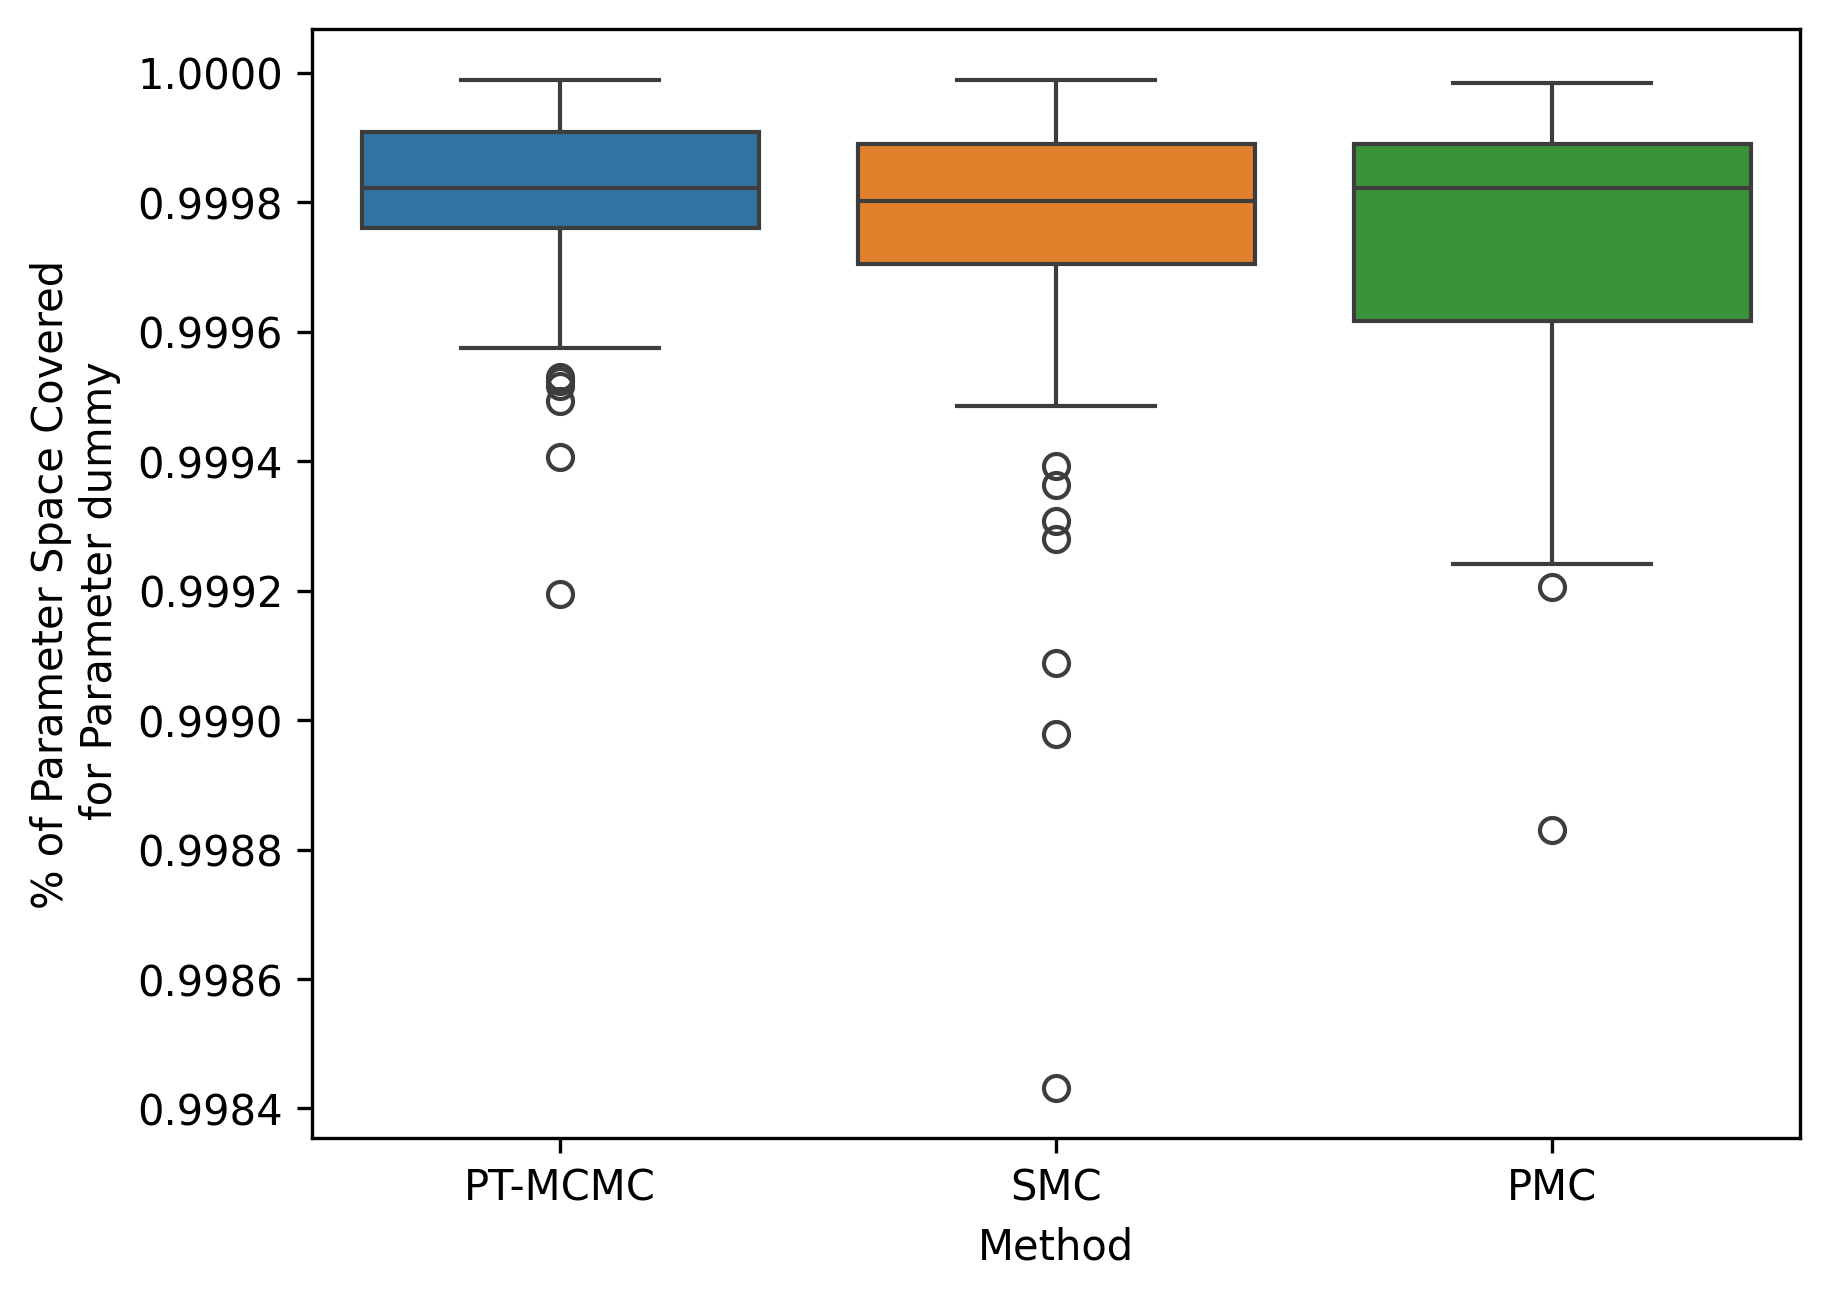

In [4]:
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

dummy_idx = -1

par_bounds = mod_prob.bounds
plt.figure(dpi=300)
ratios = np.array([x.get_sampling_efficiency(par_bounds, dummy_idx) for x in grouped_results], dtype=object)
ratio_df = pd.DataFrame()
for ratio_arr, method in zip(ratios, methods):
	temp_df = pd.DataFrame()
	temp_df[method] = ratio_arr
	ratio_df = pd.concat([ratio_df, temp_df])

sns.boxplot(ratio_df, showfliers=True)
plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
plt.xlabel("Method"); plt.ylabel(f"% of Parameter Space Covered\nfor Parameter {fit_par_names[-1]} ");

## Select best result for each method

In [5]:
llhs = np.array([x.get_avg_llhs() for x in grouped_results], dtype=object)
best_runs = [np.argmax(x) for x in llhs]
best_results = [res.all_runs[best_idx] for best_idx, res in zip(best_runs, grouped_results)]

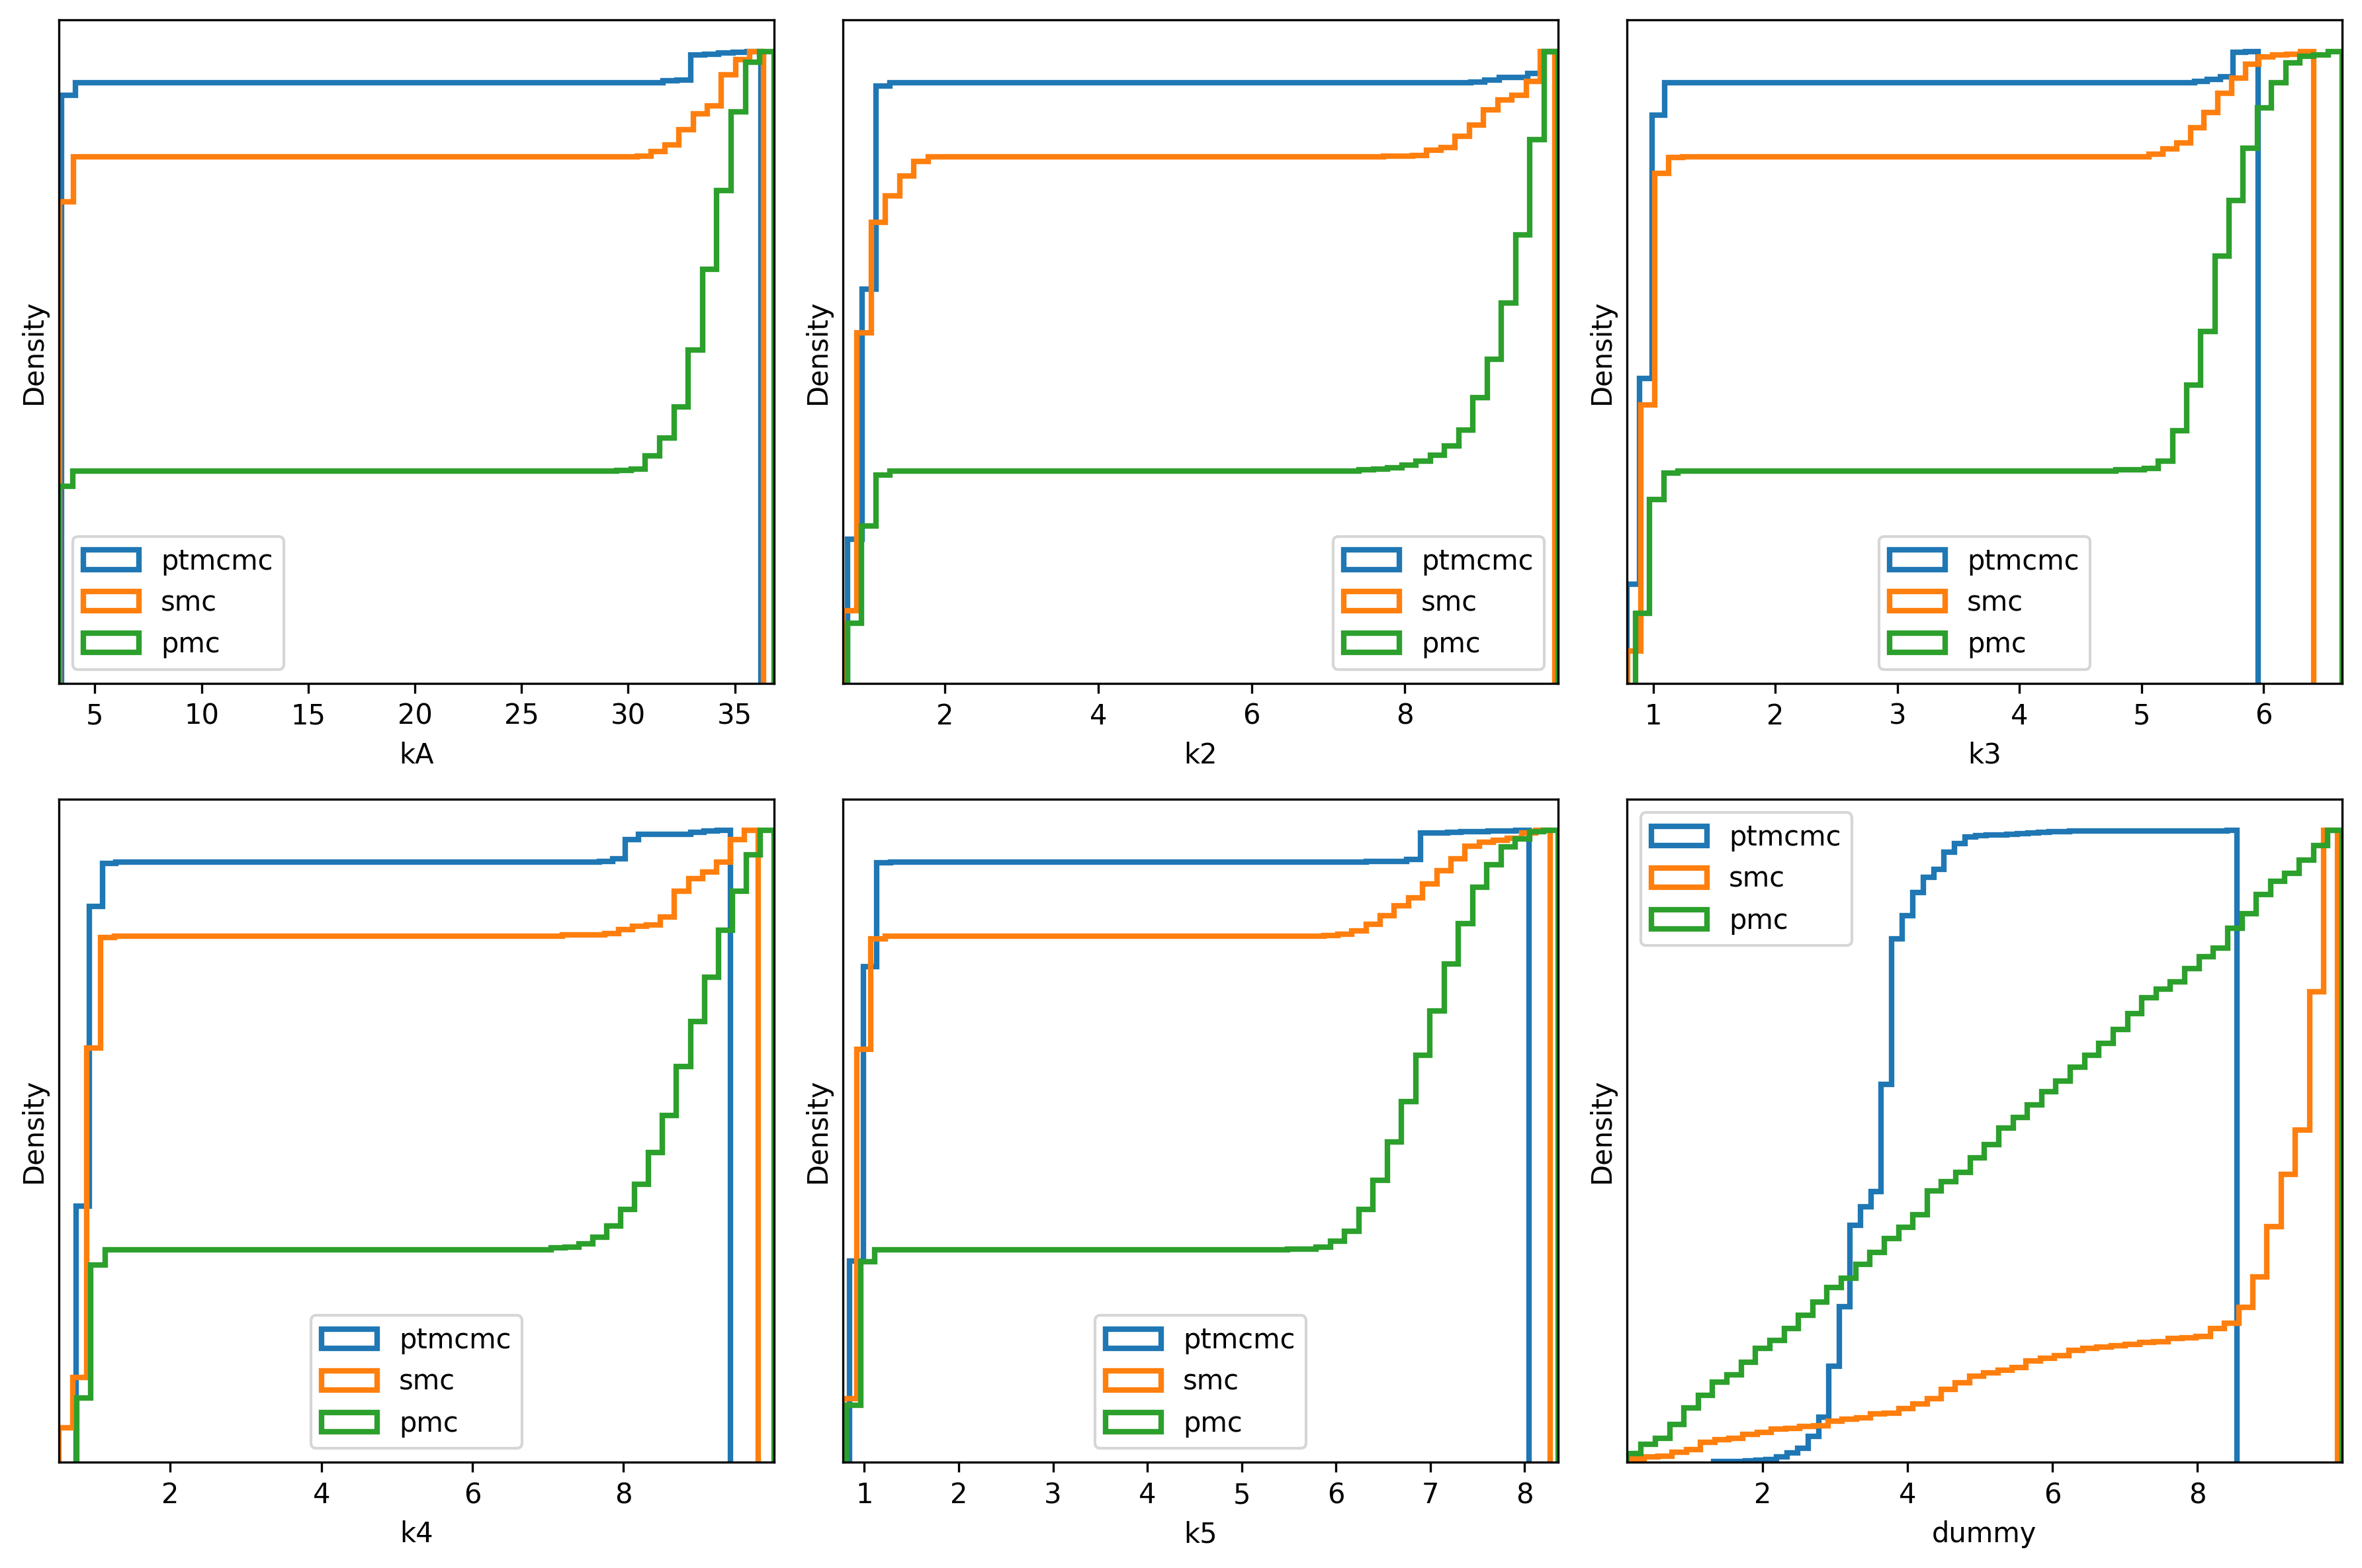

In [6]:
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
histtype = "step"
alpha=1

plt.figure(figsize=(12,8), dpi=300)
for i, par_name in enumerate(fit_par_names): 
	plt.subplot(2,3,i+1)
	for j in range(len(best_results)):      
		cur_result = best_results[j]
		norm_ws = cur_result.posterior_weights
		plt.hist(cur_result.posterior_samples[:, i], lw=2, weights=norm_ws, color=colors[j], alpha=alpha,
			 cumulative=True, histtype="step", bins=50, label=cur_result.method) 
		plt.xlabel(par_name)
		plt.yticks([])
		plt.ylabel("Density")
		plt.margins(x=0)
	plt.legend()
plt.tight_layout()

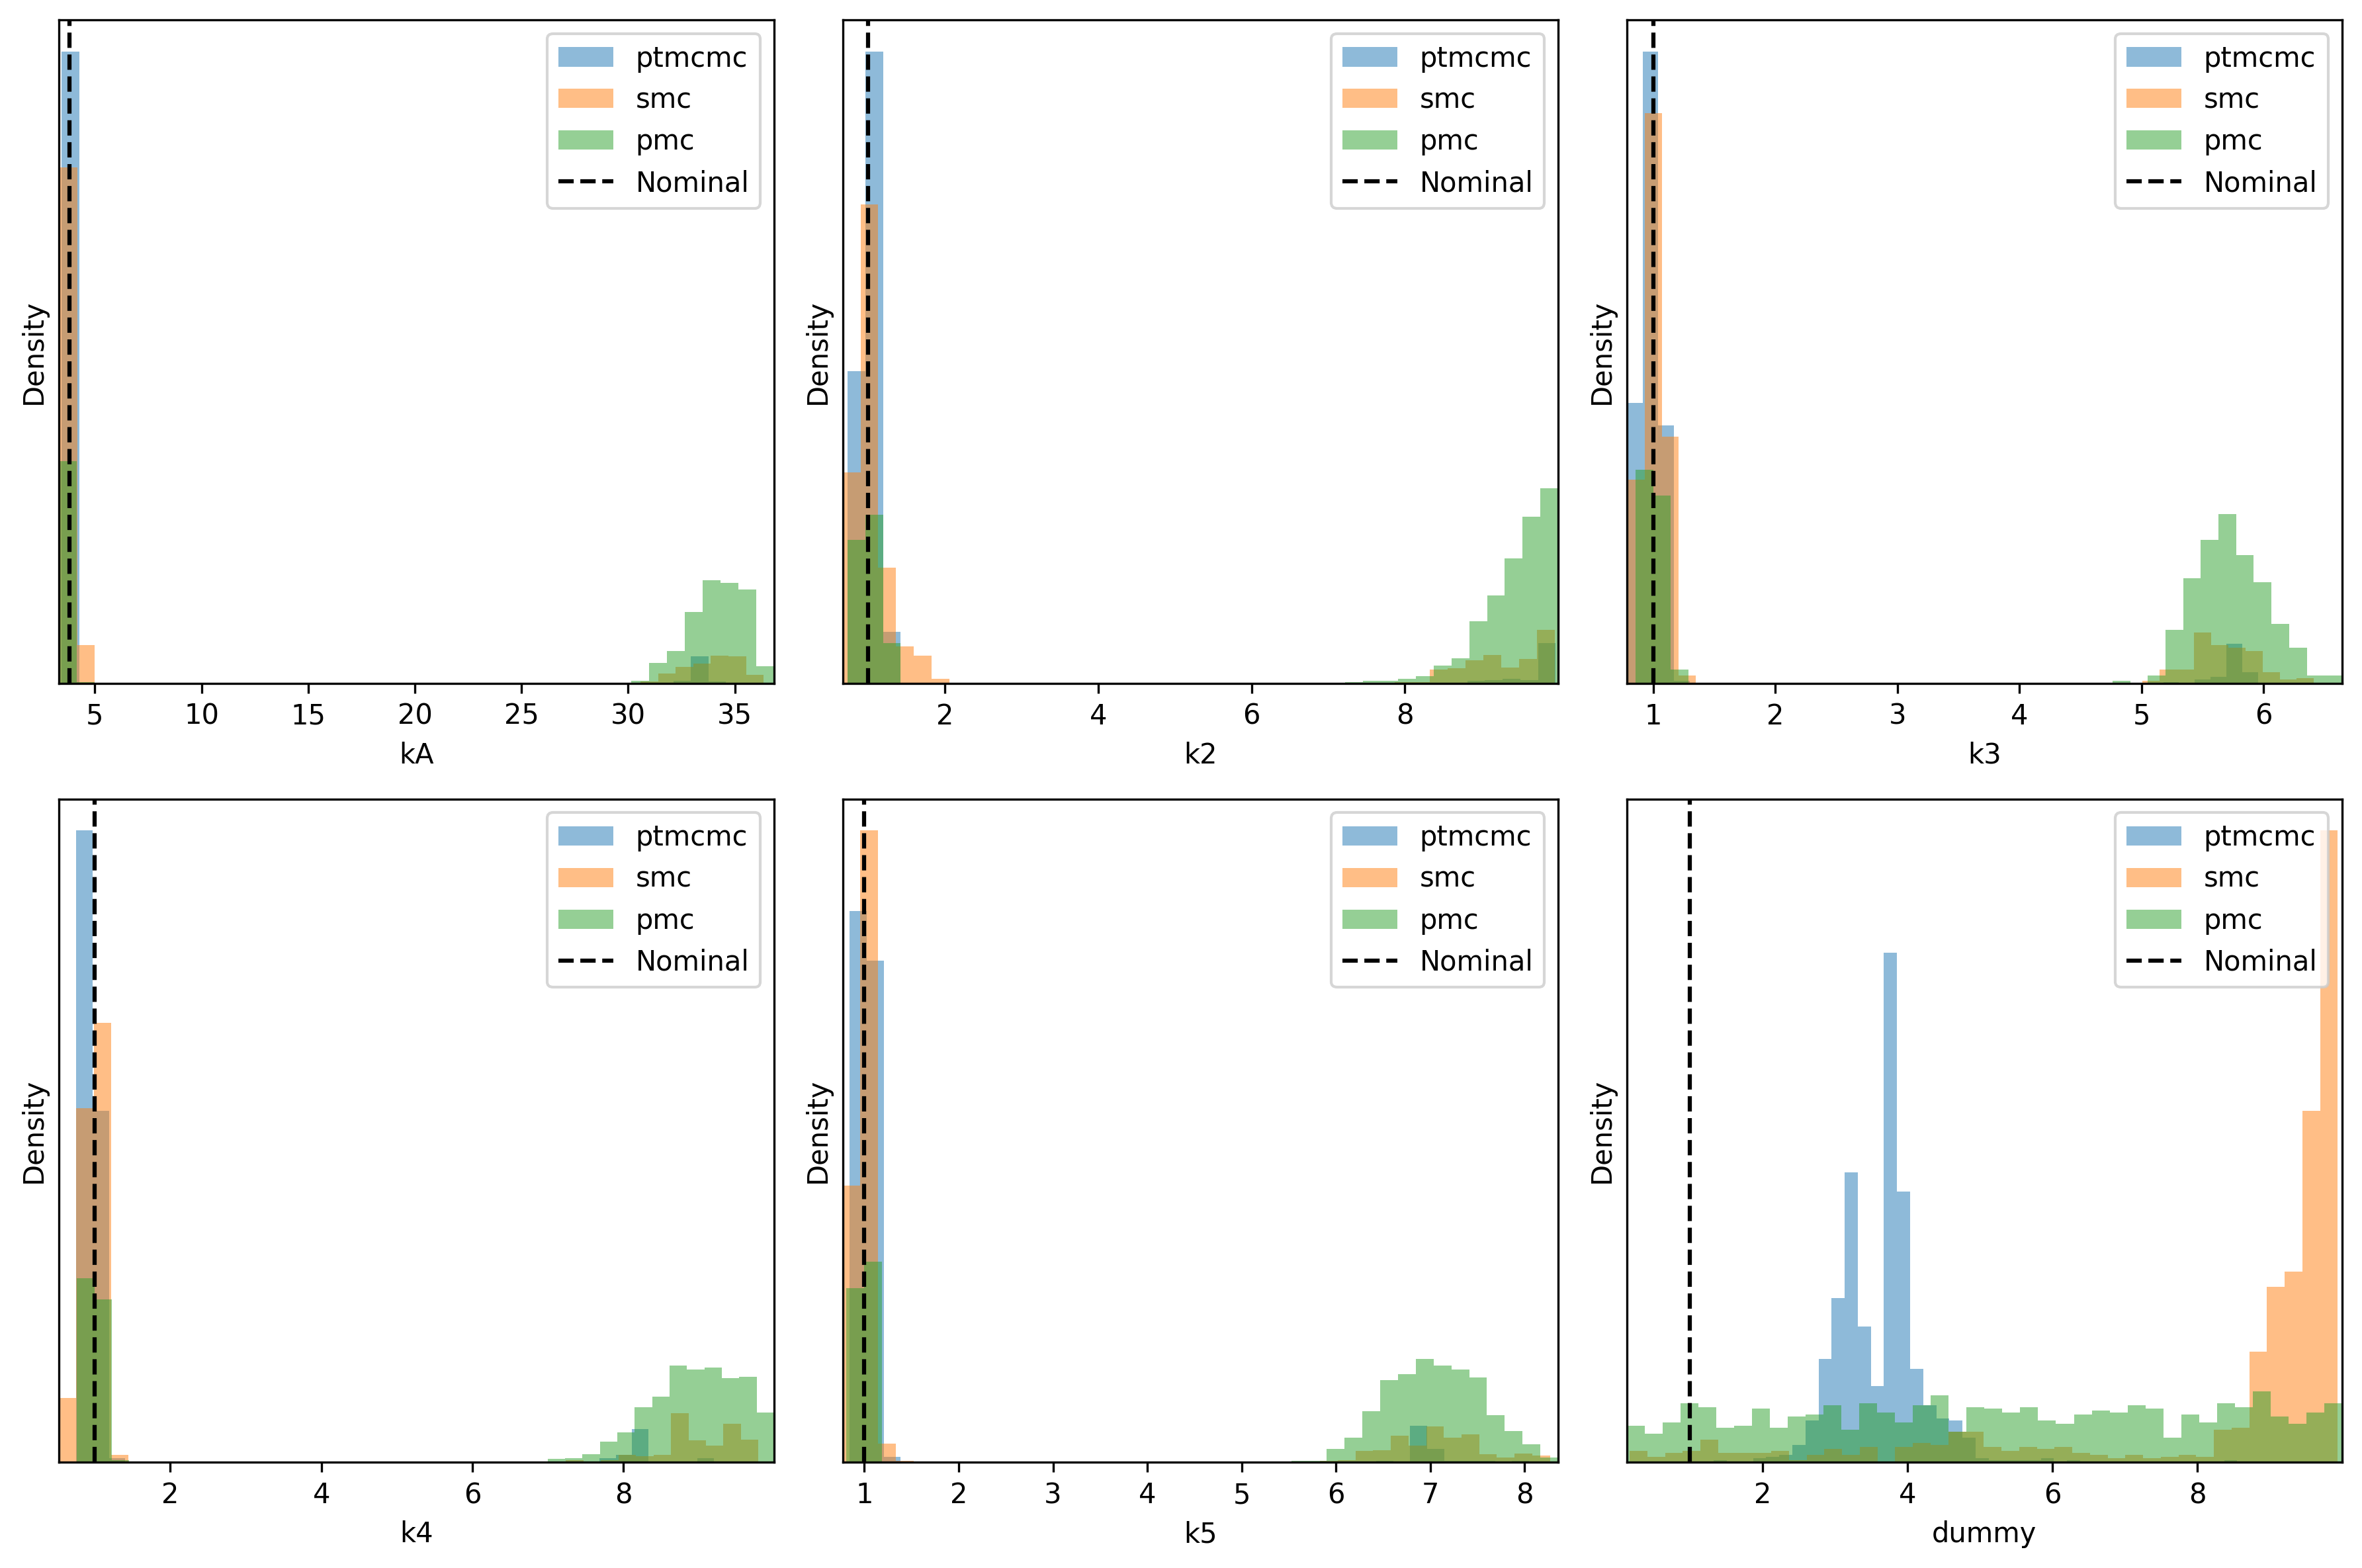

In [7]:
# Get the names of the estimated parameters
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
histtype = "bar"
alpha=0.5
xtrue = mod_prob.petab_problem.get_x_nominal(fixed=False, scaled=False)
plt.figure(figsize=(12,8), dpi=300)
for i, par_name in enumerate(fit_par_names): 
	plt.subplot(2,3,i+1)
	for j in range(len(best_results)):      
		cur_result = best_results[j]
		plt.hist(cur_result.posterior_samples[:, i], lw=2, weights=cur_result.posterior_weights, color=colors[j], alpha=alpha,
			 cumulative=False, histtype=histtype, bins=40, label=cur_result.method) 
		plt.xlabel(par_name)
		plt.yticks([])
		plt.ylabel("Density")
		plt.margins(x=0)
	plt.axvline(x=xtrue[i], ls="--", color="k", label="Nominal")
	plt.legend()
plt.tight_layout()

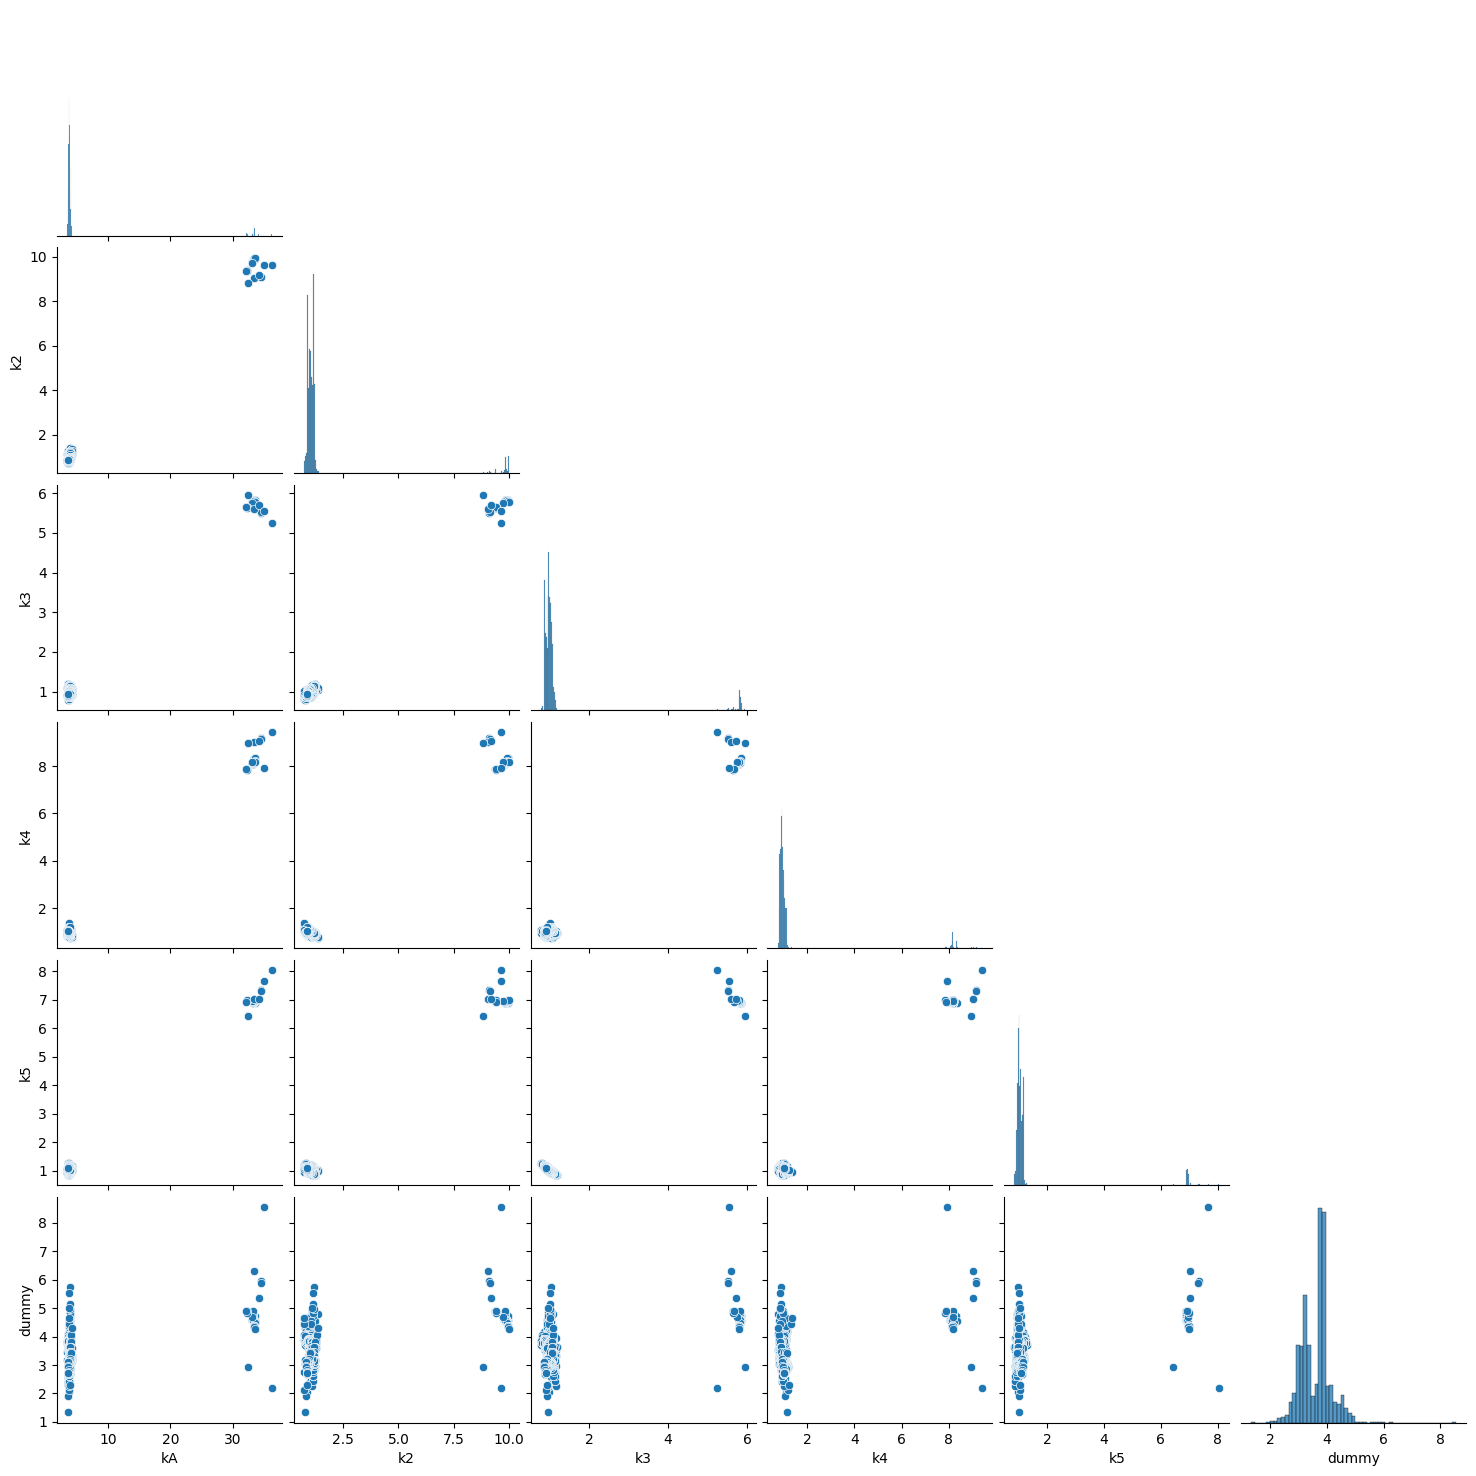

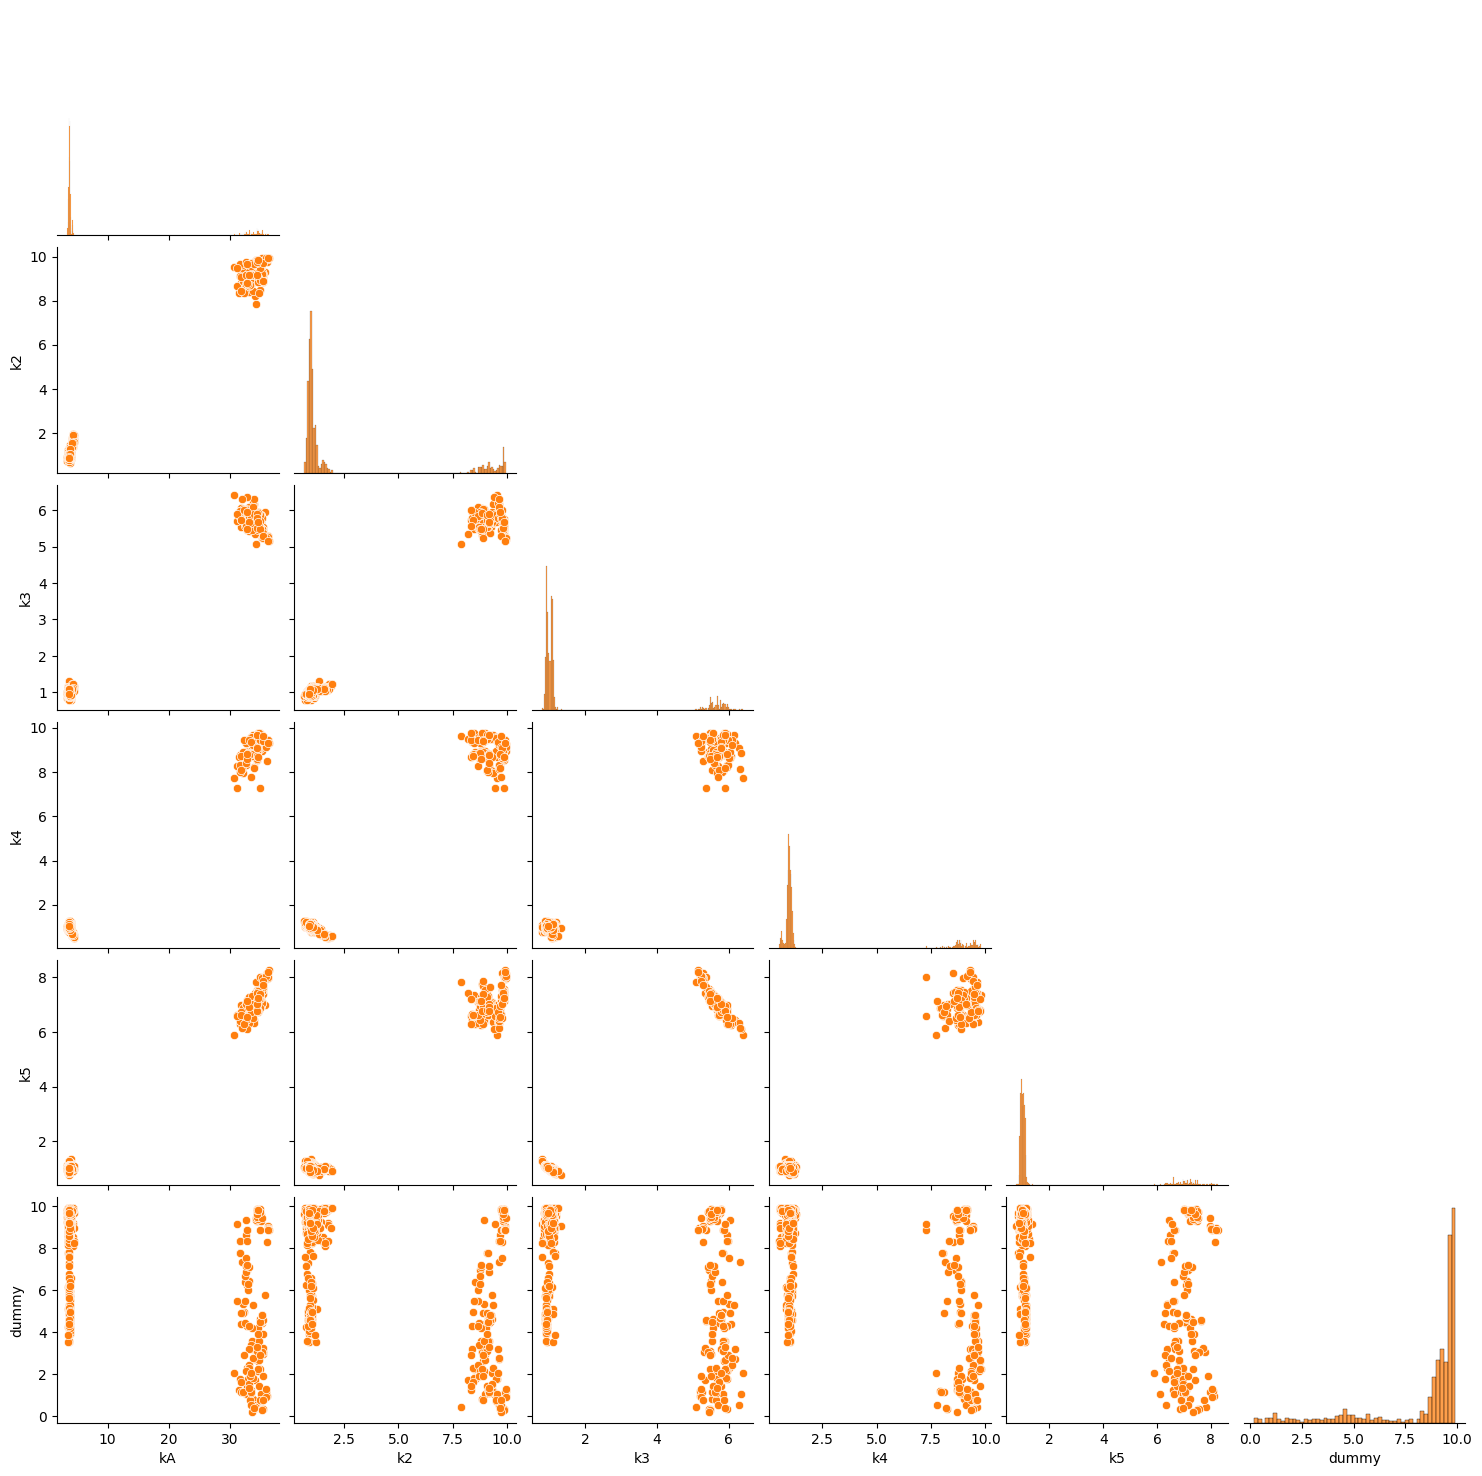

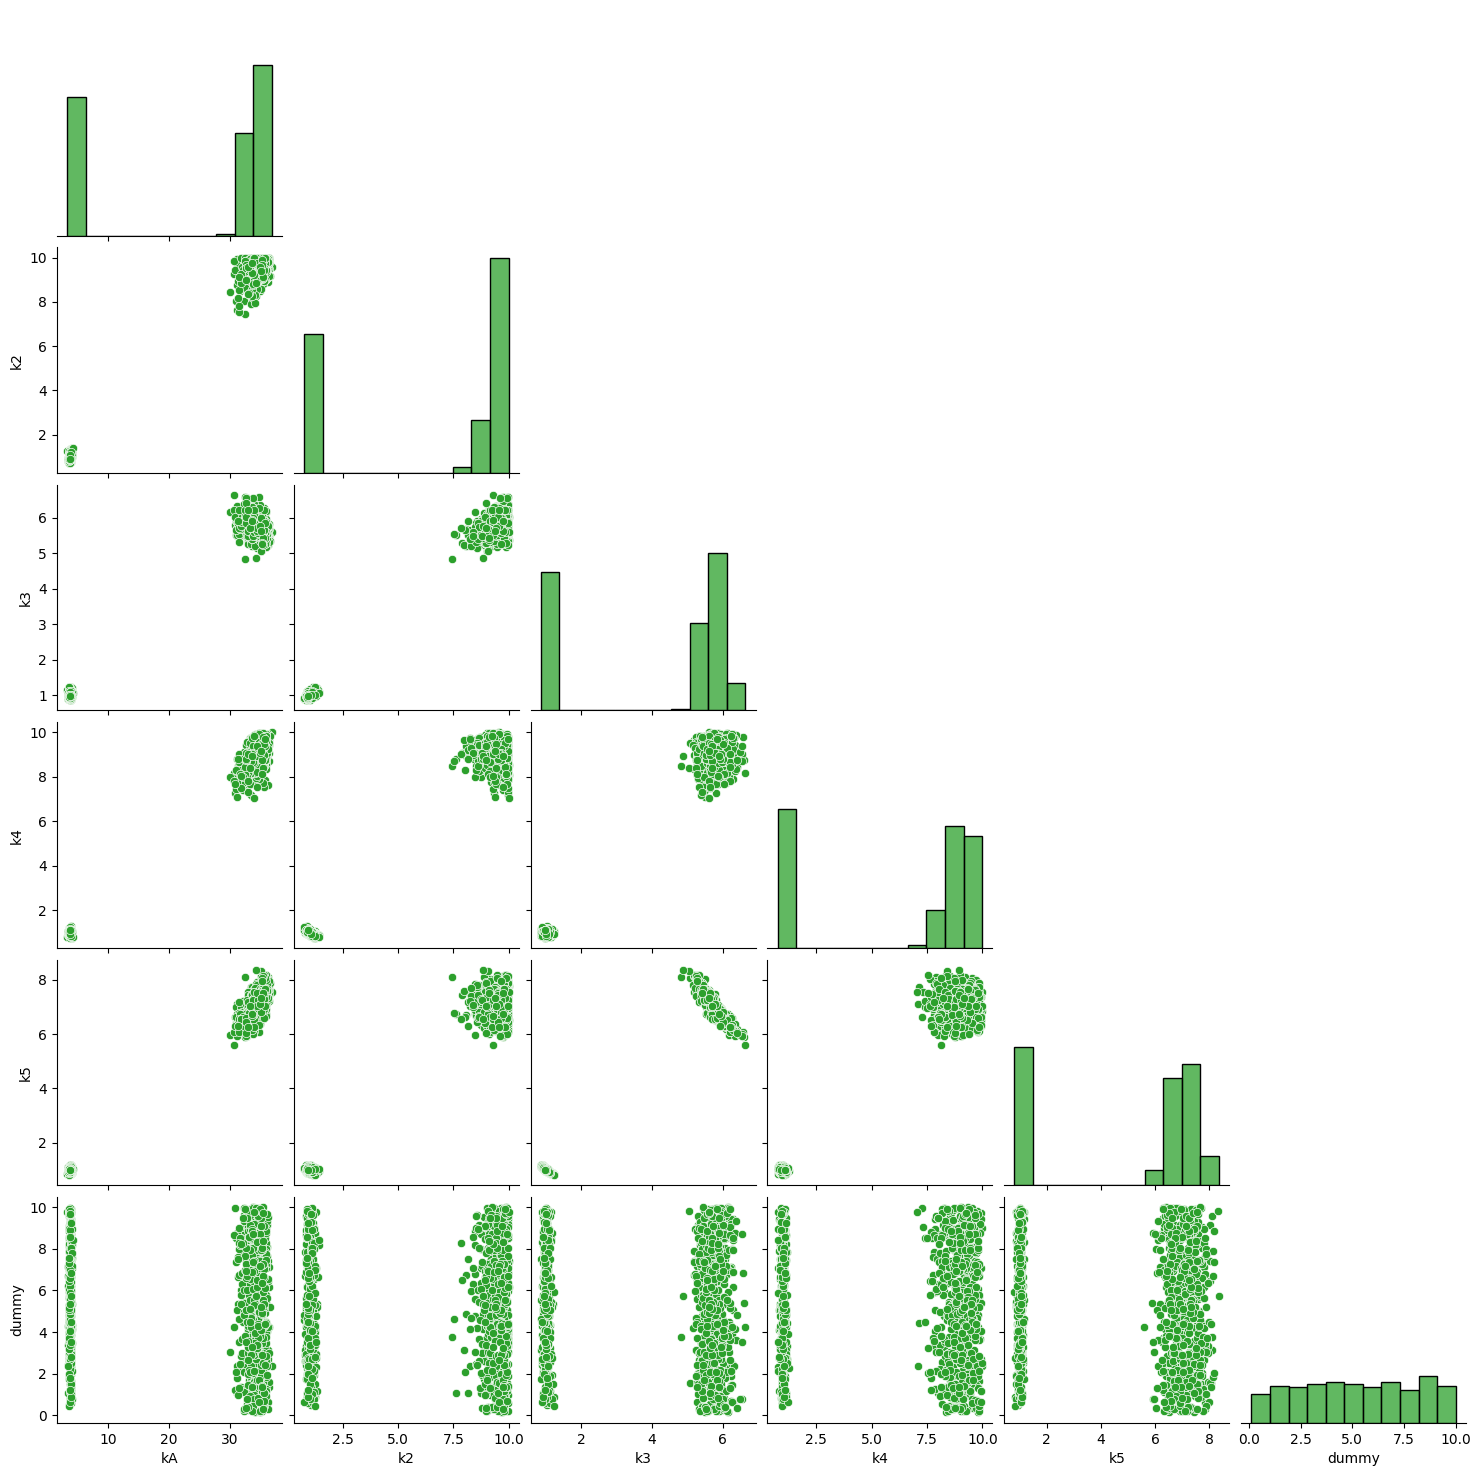

In [8]:
for i, method in enumerate(methods):
	cur_result = best_results[i]
	param_samples = cur_result.posterior_samples
	df = pd.DataFrame(data=param_samples, columns=fit_par_names)
	g = sns.pairplot(df, corner=True, diag_kws= {'color': colors[i]},
			  plot_kws={'color': colors[i]})

In [9]:
from pypesto.objective import AggregatedObjective
from pypesto.objective.roadrunner.road_runner import RoadRunnerObjective
obj = mod_prob.problem.objective
og_obj = obj
if isinstance(obj, AggregatedObjective):
    subobjs = mod_prob.problem.objective.__dict__["_objectives"]
    for subobj in subobjs:
        if isinstance(subobj, RoadRunnerObjective):
            obj = subobj
        else:
            continue

## Plot fits to model data

/home/larkinit/anaconda3/envs/test1/lib/python3.12/site-packages/petab/v1/visualize/plotting.py:737: UserWarning: For plotId plot1 in column yLabel contradictory settings (['X_{1}' 'X_{2}' 'X_{3}']). Proceeding with first entry (X_{1}).
  subplot = Subplot.from_df(


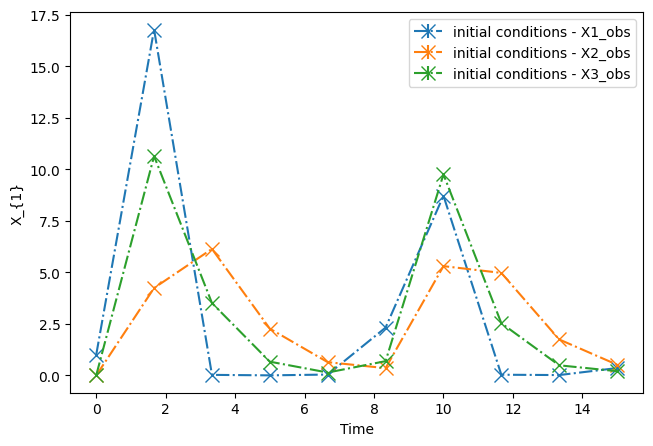

In [10]:
CI = 0.95
UPPER_PCT = (1 - (1-CI)/2)
LOWER_PCT = ((1-CI)/2)

petab_prob = mod_prob.petab_problem
ax_dict = plot_problem(petab_problem=petab_prob,) 
fig = plt.gcf()
# Change the figure size
fig.set_size_inches(6,4)

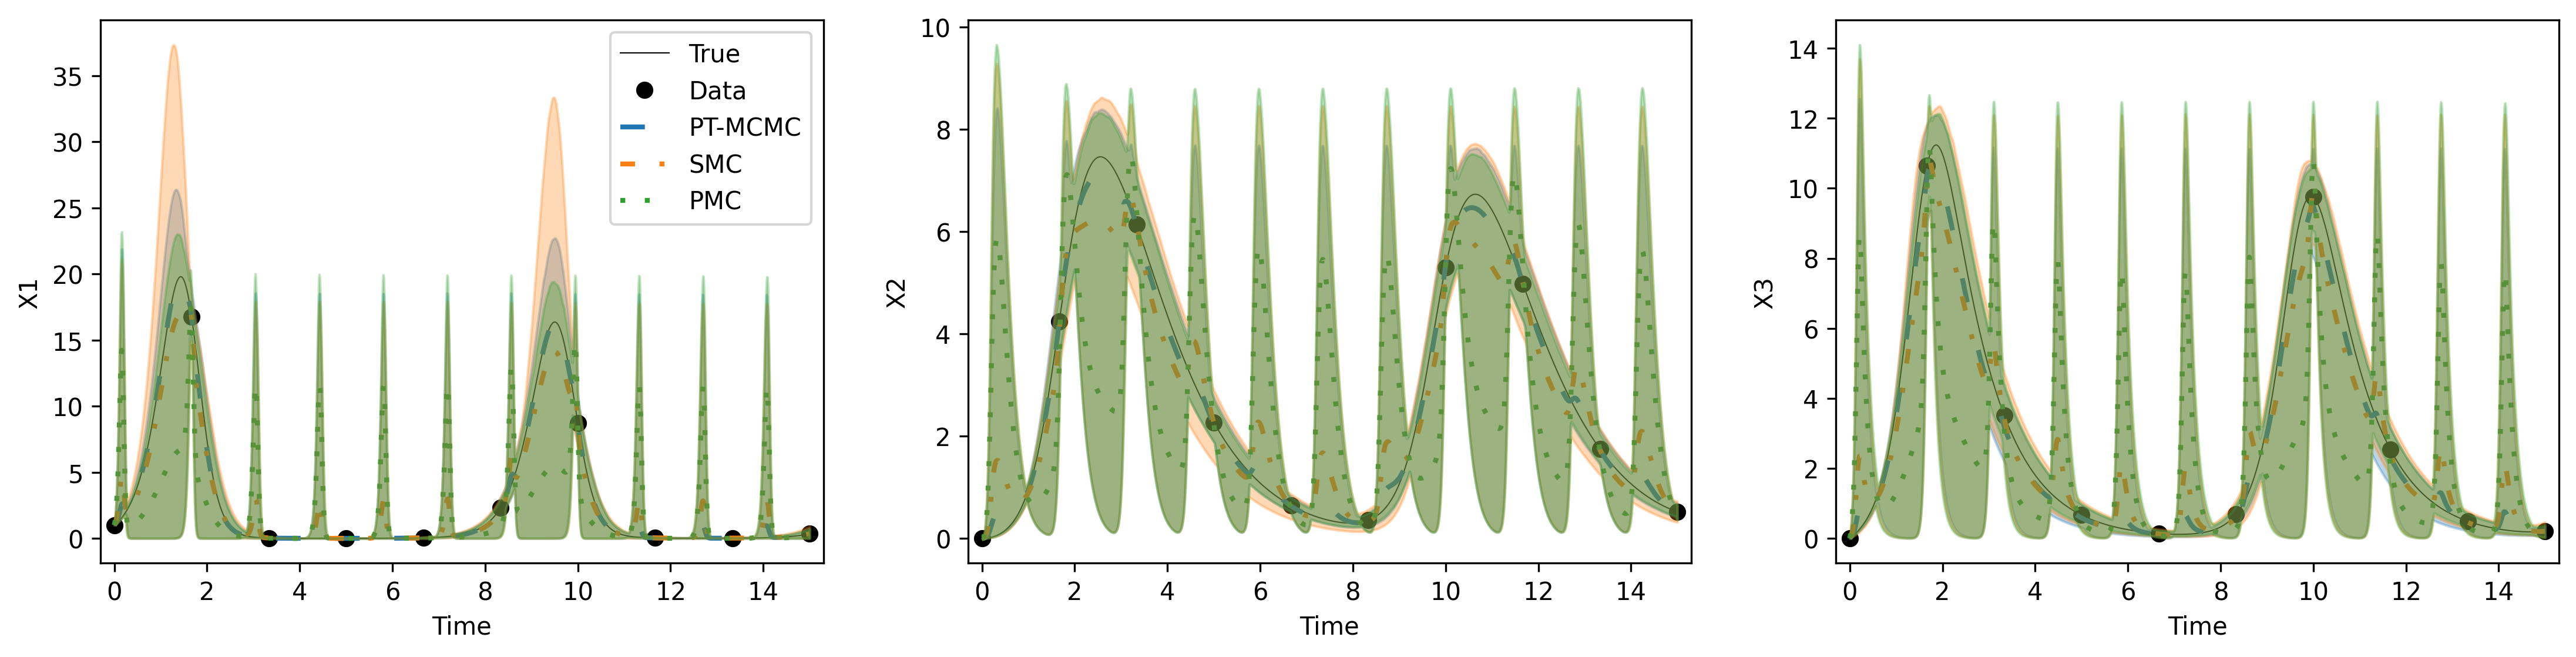

In [12]:
measure_df = petab_prob.measurement_df
species = measure_df["observableId"].unique()
data_ts = measure_df["time"].unique()
tmax = max(data_ts)
n_sim_ts = int(tmax*100 + 1)
simu = obj.roadrunner_instance
simu.resetAll()
simu.timeCourseSelections = ["time", "S1", "S2", "S3"]
og_sim = simu.simulate(0, tmax, n_sim_ts)
og_sim_ts = og_sim[:, 0]

fig, axs = plt.subplots(1,3,figsize=(18,4), dpi=300)
axs[0].plot(og_sim_ts, og_sim[:, 1], "k-", lw=0.5, label="True")
axs[0].plot(data_ts, measure_df[measure_df["observableId"]==species[0]]["measurement"], "ko", label="Data", zorder=2)

axs[1].plot(og_sim_ts, og_sim[:, 2], "k-", lw=0.5, label="True")
axs[1].plot(data_ts, measure_df[measure_df["observableId"]==species[1]]["measurement"], "ko", label="Data", zorder=2)

axs[2].plot(og_sim_ts, og_sim[:, 3], "k-", lw=0.5, label="True")
axs[2].plot(data_ts, measure_df[measure_df["observableId"]==species[2]]["measurement"], "ko", label="Data", zorder=2)

lss = [(0,(5,10)), (0,(3,5,1,5)), (0,(1,4))]

for i, best in enumerate(best_results):
	pars = best.posterior_samples
	weights = best.posterior_weights

	all_sim_data = np.empty(shape=(n_sim_ts, pars.shape[0], len(species)))

	## Collect all of the runs simulation information
	for n, par in enumerate(pars):
		#sim = obj(par, mode="mode_fun", return_dict=True)["simulation_results"]["simCondition"]
		simu.resetAll()
		simu.timeCourseSelections = ["time", "S1", "S2", "S3"]
		for name, x in zip(fit_par_names, par):
			simu[name] = x
		simu.reset()
		sim = simu.simulate(0, tmax, n_sim_ts)
		all_sim_data[:, n, :] = sim[:, 1:]
		sim_ts = sim[:, 0]

	mean_sim_data = np.average(all_sim_data, weights=weights, axis=1)
	temp1 = np.array([weighted_quantile(x[:, 0], [LOWER_PCT, UPPER_PCT], weights) for x in all_sim_data])
	temp2 = np.array([weighted_quantile(x[:, 1], [LOWER_PCT, UPPER_PCT], weights) for x in all_sim_data])
	temp3 = np.array([weighted_quantile(x[:, 2], [LOWER_PCT, UPPER_PCT], weights) for x in all_sim_data])

	axs[0].plot(sim_ts, mean_sim_data[:, 0], color=colors[i], linestyle=lss[i],
			  lw=2, label=grouped_results[i].abbr)
	axs[0].fill_between(sim_ts, temp1[:, 0], temp1[:, 1], zorder=3, alpha=0.3, color=colors[i])

	axs[1].plot(sim_ts, mean_sim_data[:, 1], color=colors[i], linestyle=lss[i],
			  lw=2, label=grouped_results[i].abbr)
	axs[1].fill_between(sim_ts, temp2[:, 0], temp2[:, 1], zorder=3, alpha=0.3, color=colors[i])

	axs[2].plot(sim_ts, mean_sim_data[:, 2], color=colors[i], linestyle=lss[i],
			  lw=2, label=grouped_results[i].abbr)
	axs[2].fill_between(sim_ts, temp3[:, 0], temp3[:, 1], zorder=3, alpha=0.3, color=colors[i])

axs[0].set_xlabel("Time")
axs[0].set_ylabel("X1")
axs[0].margins(x=0.02);
axs[1].set_xlabel("Time")
axs[1].set_ylabel("X2")
axs[1].margins(x=0.02);
axs[2].set_xlabel("Time")
axs[2].set_ylabel("X3")
axs[0].legend(loc="upper right")
axs[2].margins(x=0.02);